# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [33]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import random
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec


import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

# The library to allow the time mesure
import logging

# Libraries for data visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [34]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

Les données était récupérées de stack overflow à l'aide de code suivant :

SELECT body, title, tags FROM posts 
WHERE title is not null and body is not null and tags is not null and FavoriteCount>50


In [35]:
data_load = pd.read_csv(
    'Data/data_best_rating50.csv', sep=',')

In [36]:
data_load.shape

(19687, 3)

In [37]:
data_load.head()

,body,title,tags
0,<p>I've been using Eclipse with RDT (not RadRa...,What Ruby IDE do you prefer?,<ruby><ide><editor>
1,<p>We are developing an application that invol...,How to generate sample XML documents from thei...,<xml><xsd><dtd><test-data>
2,<p>I know that IList is the interface and List...,When to use IList and when to use List,<c#><.net>
3,<p>I develop C++ applications in a Linux envir...,What tools do you use to develop C++ applicati...,<c++><linux><eclipse><gdb><valgrind>
4,<p>What would be the most efficient way to com...,What is the most effective way for float and d...,<c++><algorithm><optimization><floating-point>


Exemple de la première question:

In [38]:
print (data_load['body'][2])

<p>I know that IList is the interface and List is the concrete type but I still don't know when to use each one. What I'm doing now is if I don't need the Sort or FindAll methods I use the interface. Am I right? Is there a better way to decide when to use the interface or the concrete type?</p>



## Création d'un jeu de données test

Notre variable cible est la variable tags. Nous avons deux variables texte qui nous permettrons estimer le tag : variables title et body. Nous allons séparer 30 % de données qui seront utilisées plus tard afin de tester les modèles :

In [39]:
target = data_load['tags']

In [40]:
data=data_load.drop(['tags'], axis=1)

In [41]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.5, random_state=1)

In [42]:
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 9843 observations et 2 features.
Le vecteur y_train contient 9843 observations.
Le jeu de données X_test contient 9844 observations et 2 features.
Le vecteur y_test contient 9844 observations.


Exporter les jeux de données en .csv

In [43]:
X_train.to_csv('Data/X_train.csv', sep='\t')
X_test.to_csv('Data/X_test.csv', sep='\t')
y_train.to_csv('Data/y_train.csv', sep='\t', header=False)
y_test.to_csv('Data/y_test.csv', sep='\t', header=False)

# Data cleaning 

## Tester les fonctions sur un exemple de features

### Enlever les balises html

Pour enlever les balises HTML, nous allons utiliser le package BeautifulSoup:

In [12]:
# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(X_train['body'][1])  

# Print the raw review and then the output of get_text(), for 
# comparison
print (X_train['body'][1])
print (example1.get_text())

<p>We are developing an application that involves a substantial amount of XML transformations. We do not have any proper input test data per se, only DTD or XSD files. We'd like to generate our test data ourselves from these files. Is there an easy/free way to do that?</p>

<p><strong>Edit</strong></p>

<p>There are apparently no free tools for this, and I agree that OxygenXML is one of the best tools for this.</p>

We are developing an application that involves a substantial amount of XML transformations. We do not have any proper input test data per se, only DTD or XSD files. We'd like to generate our test data ourselves from these files. Is there an easy/free way to do that?
Edit
There are apparently no free tools for this, and I agree that OxygenXML is one of the best tools for this.



### Enlever la ponctuation

Nous allons enlever la ponctuation tout en gardant les nombres, lettres ainsi que les signes "-", "+" et "#" étant donné que ces signes sont souvent utilisés dans l'informatique. 

In [13]:
letters_only = re.sub("[^#+a-zA-Z]",       # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

We are developing an application that involves a substantial amount of XML transformations  We do not have any proper input test data per se  only DTD or XSD files  We d like to generate our test data ourselves from these files  Is there an easy free way to do that  Edit There are apparently no free tools for this  and I agree that OxygenXML is one of the best tools for this  


### Mise en minuscule et tokenization

In [14]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

### Stopwords

In [15]:
# Let's have a look to the stopwords from ntlk.corpus
print (stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['developing', 'application', 'involves', 'substantial', 'amount', 'xml', 'transformations', 'proper', 'input', 'test', 'data', 'per', 'se', 'dtd', 'xsd', 'files', 'like', 'generate', 'test', 'data', 'files', 'easy', 'free', 'way', 'edit', 'apparently', 'free', 'tools', 'agree', 'oxygenxml', 'one', 'best', 'tools']


### Lemmatisation

In [17]:
lemmatizer = WordNetLemmatizer() 

lems = []

for word in words:
    word = lemmatizer.lemmatize(word)
    lems.append(word)
    
print(lems)

['developing', 'application', 'involves', 'substantial', 'amount', 'xml', 'transformation', 'proper', 'input', 'test', 'data', 'per', 'se', 'dtd', 'xsd', 'file', 'like', 'generate', 'test', 'data', 'file', 'easy', 'free', 'way', 'edit', 'apparently', 'free', 'tool', 'agree', 'oxygenxml', 'one', 'best', 'tool']


## Tester les fonctions sur un exemple de targets

Les tags (notre variable cible) ont une forme spécifiques. Les mots sont entre "<>". Les tags sont parfois composés par deux, voir plusieurs mots qui sont séparés par "-". Nous allons enlever les balises.

In [18]:
#Take the first tag from the dataset
tag = y_train[1]

In [19]:
#Check
tag

'<xml><xsd><dtd><test-data>'

In [20]:
#Remove first '<'
tag = tag[1:]

In [21]:
#Check
tag

'xml><xsd><dtd><test-data>'

In [22]:
#Remove last '>'
tag = tag[:-1]

In [23]:
#Check
tag

'xml><xsd><dtd><test-data'

In [24]:
#Remove remaining '><' signs
tag = tag.split('><')

In [25]:
#Check
tag

['xml', 'xsd', 'dtd', 'test-data']

In [26]:
#Converting back to string
tag_clean = " ".join(tag)  

In [27]:
#Check
tag_clean

'xml xsd dtd test-data'

## Pipelines pour data cleaning

### Features

Nous allons utiliser la fonction suivante pour automatiser le processus de data cleaning :

In [44]:
def post_to_words( raw_post ):
    """Function to convert a raw document to a string of words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove HTML
    post_text = BeautifulSoup(raw_post).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^#+a-zA-Z]", " ", post_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in meaningful_words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
    #
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( lems )) 

In [45]:
X_train['body_clean']=X_train['body'].apply(lambda x: post_to_words(x))

In [46]:
X_train['title_clean']=X_train['title'].apply(lambda x: post_to_words(x))

In [47]:
X_train.head()

,body,title,body_clean,title_clean
4183,<p>For some reason it looks like constructor d...,How do I create a custom Error in JavaScript?,reason look like constructor delegation work f...,create custom error javascript
13188,<p>How long can latitude and longitude be?</p>...,What is the maximum length of latitude and lon...,long latitude longitude getting long length se...,maximum length latitude longitude
2147,<p>How can I get crash data (stack traces at l...,How do I obtain crash-data from my Android app...,get crash data stack trace least android appli...,obtain crash data android application
7588,<p>I'm wondering what the best way is to have ...,".NET - What's the best way to implement a ""cat...",wondering best way else fails catch mean handl...,net best way implement catch exception handler
12329,<p>I need to parse an RSS feed (XML version 2....,How to parse an RSS feed using JavaScript?,need parse r feed xml version display parsed d...,parse r feed using javascript


Nous allons aussi construire une fonction qui nous servira comme paramètre de tokenizer personnalisé que nous allons appliquer dans l'outil CountVectorizer, afin de garder la structure de bigrams que l'on a créé pendant la transformation de features. Nous allons séparer les mot tout simplement en utilisant méthode .split() qui sépare les mots par espace et laisse les caractères spéciaux comme par exemple '#' collé sur les mots, contrairement à la méthode .tokenize() 

In [48]:
def my_tokenizer(doc):
    
    """Function defining personalized tokenizer for sklearn's CountVectorizer in order to keep the created 
    bigrams in tag's format.
    
    Input:
    
    - doc : string to be tokenized
    
    Output:
    
    - tokenized string
    """
    
    
    tokens = doc.split()
    
    return tokens

Nous allons définir les stop-words que nous n'avons pas enlevé dans l'étape de cleaning, mais qui figurent souvent dans les posts et qui n'ont pas de valeur informative. La liste sera également utilée en paramètre de CountVectorizer et TfidfVectorizer.

In [49]:
stop_words = ["i'm", 'would', '1', '0', '2', "i've", 'could', 'anyone', 'also', '3', 'thanks', 
               'two', 'however', "i'd", '5', "+", "#", "im", "ive", "dont", "cant", "id", ")", "("]

### Target

In [50]:
def cleaning_target(raw_target):
    """Function to remove '<>' signs from target list and to replace them with a space
    
    Arguments :
    - raw_target : a Series of tags
    
    Return :
    - Series with cleaned tags
       
    """
    
    #Remove first '<'
    tag = raw_target[1:]
    
    #Remove last '>'
    tag = tag[:-1]
    
    #Remove remaining '><' signs
    tag = tag.split('><')
    
    #Converting back to string
    tag_clean = " ".join(tag)  
    
    return tag_clean

In [51]:
y_train_clean=y_train.apply(lambda x: cleaning_target(x))

In [52]:
y_train_clean.head()

4183                     javascript exception
13188      database-design latitude-longitude
2147                android crash stack-trace
7588     c# .net exception exception-handling
12329                     javascript html rss
Name: tags, dtype: object

# Feature engineering

## Créer les bigrams

Nous allons créer des bigrams, car les tags sont souvent composés par deux mots, séparés par "-". Les bigrams créé à partir de text de body et title vont donc être mis au même format que les tags.

### Tester les fonctions sur un exemple de post

In [37]:
#Take the first element of the cleaned body text
body = X_train['body_clean'][1]
body

'developing application involves substantial amount xml transformation proper input test data per se dtd xsd file like generate test data file easy free way edit apparently free tool agree oxygenxml one best tool'

In [38]:
#Split it to a list of words
body = body.split()

In [39]:
#Check
body[:10]

['developing',
 'application',
 'involves',
 'substantial',
 'amount',
 'xml',
 'transformation',
 'proper',
 'input',
 'test']

In [40]:
#Creating bigrams object
bigram = nltk.bigrams(body)

In [41]:
#Creating a list of bigram objects
liste = list(bigram)

In [42]:
#Check
liste[:10]

[('developing', 'application'),
 ('application', 'involves'),
 ('involves', 'substantial'),
 ('substantial', 'amount'),
 ('amount', 'xml'),
 ('xml', 'transformation'),
 ('transformation', 'proper'),
 ('proper', 'input'),
 ('input', 'test'),
 ('test', 'data')]

In [43]:
#Creating a tag-like word from tuples
bigrams_rec = []

for i in range(len(liste)):
    tuple1 = liste[i]
    elt = tuple1[0] + '-' + tuple1[1]
    bigrams_rec.append(elt)

In [44]:
#Creating a string from list of tag-like bigrams
bigrams_str = " ".join(bigrams_rec)

### Créer des pipelines pour le recodage en bigrams

Nous allons utiliser deux fonctions afin de :
    1. créer les bigrams
    2. recoder les bigrams dans le même format comme les tags dans notre variable cible

In [53]:
def create_bigrams(var):
    
    """Function which generates a liste of tuples representing bigrams. 
    
    Arguments :
    - var : feature to be recoded
    
    Returns :
    - a Series of recoded feature  
    
    """
   
   #Take the i-th element of the cleaned body text
    body = var    
        
    #Split it to a list of words
    body = body.split()
    
    #Creating bigrams object
    bigram = nltk.bigrams(body)
    
    #Creating a list of bigram objects 
    liste_bigram = list(bigram)
        
        
    return liste_bigram

In [54]:
X_train['body_bigram'] = X_train['body_clean'].apply(lambda x : create_bigrams(x))

In [55]:
X_train['body_bigram'].head()

4183     [(reason, look), (look, like), (like, construc...
13188    [(long, latitude), (latitude, longitude), (lon...
2147     [(get, crash), (crash, data), (data, stack), (...
7588     [(wondering, best), (best, way), (way, else), ...
12329    [(need, parse), (parse, r), (r, feed), (feed, ...
Name: body_bigram, dtype: object

In [56]:
def recode_bigrams(liste):
    """Function which recode the bigrams generated by recode_bigram function.
    Each bigram has the same structure as the stack overflow tages :
    it is composed of two words and the words are separated by '-'  
    
    Arguments :
    - liste : a liste containing bigram tuples
    
    Return :
    
    - a string of recoded bigrams_rec
    """
    
    #Creating a tag-like word from tuples
    bigrams_rec = []

    for i in range(len(liste)):
        tuple1 = liste[i]
        elt = tuple1[0] + '-' + tuple1[1]
        bigrams_rec.append(elt)
        
    return " ".join(bigrams_rec)

In [57]:
X_train['body_bigram_clean'] = X_train['body_bigram'].apply(lambda x : recode_bigrams(x))

In [58]:
X_train['body_bigram_clean'].head()

4183     reason-look look-like like-constructor constru...
13188    long-latitude latitude-longitude longitude-get...
2147     get-crash crash-data data-stack stack-trace tr...
7588     wondering-best best-way way-else else-fails fa...
12329    need-parse parse-r r-feed feed-xml xml-version...
Name: body_bigram_clean, dtype: object

Nous allons appliquer les mâmes fonctions sur la feature title :

In [59]:
X_train['title_bigram'] = X_train['title_clean'].apply(lambda x : create_bigrams(x))

In [60]:
X_train['title_bigram_clean'] = X_train['title_bigram'].apply(lambda x : recode_bigrams(x))

In [61]:
X_train['title_bigram_clean'].head()

4183           create-custom custom-error error-javascript
13188    maximum-length length-latitude latitude-longitude
2147     obtain-crash crash-data data-android android-a...
7588     net-best best-way way-implement implement-catc...
12329           parse-r r-feed feed-using using-javascript
Name: title_bigram_clean, dtype: object

### Fusionner le title, body et les bigrams

Afin de simplifier le travail exploratiore et les recodages de text qui va être utilisé dans la partie analyse, nous allons créer une feature unique composée par le text de title, de body et des bigrams créés à partir de ces deux features :

In [63]:
X_train['post'] = X_train['title_clean'] + " " + X_train['body_clean'] + " " + X_train['body_bigram_clean'] + " " + X_train['title_bigram_clean']  

In [64]:
X_train['post'].head()

4183     create custom error javascript reason look lik...
13188    maximum length latitude longitude long latitud...
2147     obtain crash data android application get cras...
7588     net best way implement catch exception handler...
12329    parse r feed using javascript need parse r fee...
Name: post, dtype: object

In [65]:
X_train['post'][1]

'generate sample xml document dtd xsd developing application involves substantial amount xml transformation proper input test data per se dtd xsd file like generate test data file easy free way edit apparently free tool agree oxygenxml one best tool developing-application application-involves involves-substantial substantial-amount amount-xml xml-transformation transformation-proper proper-input input-test test-data data-per per-se se-dtd dtd-xsd xsd-file file-like like-generate generate-test test-data data-file file-easy easy-free free-way way-edit edit-apparently apparently-free free-tool tool-agree agree-oxygenxml oxygenxml-one one-best best-tool generate-sample sample-xml xml-document document-dtd dtd-xsd'

### Bag of words

Nous allons transformer les données text en matrice creuse, appelée Bag-of-Words, qui indique le nombre d'apparitions d'un mot dans la chaîne de caractères. A l'aide de cette transformation, nous allons pouvoir effectuer des opérations numériques sur les chaînes de caractères, notamment calculer des caractéristiques univariées telles que fréquences.  


La matrice représentant Bag-of-Words contient autant de colonnes que le nombre de mots dans le corpus (ensemble de posts dans notre cas). Nous allons utiliser une option max_features = 50 000 qui limite le nombre de features à 50 000.

#### Feature

In [66]:
#First execution
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_bow = X_train_bow.toarray()

Creating the bag of words...



In [58]:
X_train_bow.shape

(9843, 5000)

In [59]:
# Create a vocabulary of features
X_train_vocab_bow = vectorizer.get_feature_names()

In [60]:
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [61]:
freq_features_bow = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow['Pourcentage'] = round(freq_features_bow['Frequence']*100/sum(freq_features_bow['Frequence']),2)
freq_features_bow[:50]

,Word,Frequence,Pourcentage
1545,file,5163,0.77
4596,use,4466,0.67
4625,using,4357,0.65
2449,like,4116,0.61
161,android,3923,0.59
1753,get,3630,0.54
732,code,3509,0.52
4792,way,3475,0.52
4137,string,3149,0.47
677,class,3143,0.47


Nous constatons que dans les 50 mots les plus courants, nous avons des expressions qui ne nous apporte pas de valeur informative - nous allons donc actualiser la liste de stop words à enlever et réexécuter la transformation en BOW.

In [67]:
#Stop-words update
stop_words += ['using', 'use', 'way', 'want', 'new', 'one', 'work', 'need', 'example', 'know',
               'question', '4', 'line', 'make', '*', 'something', 'find', 'problem', 'following', 
               'create', 'x', 'run', "'", 'trying', 'change', 'used', 'see', 'possible', 'tried', 
               'first', 'without', 'found', 'seems', 'e', 'different', 'b', '8', '10', 'best', 
               'thing', "can't", '6', 'simple', 'answer', '7', 'working', 'good', 'look', 'right', 
               'help', 'another', 'v', 'try', 'point', 'would-like', '0-0', 'default', 'able', 'really', 
               'say', 'looking', 'show', 'idea', 'n', 'even', 'understand', 'better', 'please', 'p',
               'instead', 'think', 'else', 'etc', '$', '9', 'since', 'already', 'give', 'sure']

In [68]:
#Second execution after stop-words update
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_bow = X_train_bow.toarray()

Creating the bag of words...



In [64]:
# Second execution
X_train_bow.shape

(9843, 5000)

In [65]:
# Second execution
# Create a vocabulary of features
X_train_vocab_bow = vectorizer.get_feature_names()

In [66]:
# Second execution
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [67]:
# Second execution
freq_features_bow = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow['Pourcentage'] = round(freq_features_bow['Frequence']*100/sum(freq_features_bow['Frequence']),2)
freq_features_bow[:50]

,Word,Frequence,Pourcentage
1552,file,5163,0.89
2457,like,4116,0.71
162,android,3923,0.67
1756,get,3630,0.62
733,code,3509,0.60
4140,string,3149,0.54
677,class,3143,0.54
1705,function,3019,0.52
1018,data,2827,0.48
2272,java,2683,0.46


#### Titre uniquement

In [68]:
X_train_title_bow = vectorizer.fit_transform(X_train['title_clean'])

# Numpy arrays are easy to work with, so convert the result to an array
X_train_title_bow = X_train_title_bow.toarray()

In [69]:
X_train_title_bow.shape

(9843, 5000)

In [70]:
# Create vocabulary
X_train_title_vocab_bow = vectorizer.get_feature_names()

In [71]:
# Sum up the counts of each vocabulary word
X_train_title_dist_bow = np.sum(X_train_title_bow, axis=0)

In [72]:
freq_features_bow_titre = DataFrame(zip(X_train_title_vocab_bow, X_train_title_dist_bow))
freq_features_bow_titre.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow_titre.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow_titre['Pourcentage'] = round(freq_features_bow_titre['Frequence']*100/sum(freq_features_bow_titre['Frequence']),2)
freq_features_bow_titre[:50]

,Word,Frequence,Pourcentage
1624,file,645,1.40
1356,difference,499,1.08
3330,python,457,0.99
180,android,445,0.96
2238,java,421,0.91
1786,git,416,0.90
4077,string,401,0.87
2249,javascript,380,0.82
1747,get,354,0.77
2457,list,242,0.52


#### Cible

In [69]:
print ("Creating the bag of words...\n")

y_train_bow = vectorizer.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_bow = y_train_bow.toarray()

Creating the bag of words...



In [70]:
y_train_bow.shape

(9843, 4998)

In [71]:
# Creating tag's vocabulary
y_train_vocab_bow = vectorizer.get_feature_names()

In [72]:
# Sum up the counts of each vocabulary word
y_train_dist_bow = np.sum(y_train_bow, axis=0)

In [73]:
freq_target_bow = DataFrame(zip(y_train_vocab_bow, y_train_dist_bow))
freq_target_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target_bow['Pourcentage'] = round(freq_target_bow['Frequence']*100/sum(freq_target_bow['Frequence']),2)
freq_target_bow[:50]

,Word,Frequence,Pourcentage
2404,javascript,1039,3.29
3558,python,948,3.01
2377,java,872,2.76
118,android,710,2.25
663,c#,582,1.84
1808,git,524,1.66
668,c++,433,1.37
2305,ios,373,1.18
2442,jquery,353,1.12
2063,html,351,1.11


In [ ]:
# !!! Test

In [75]:
# Target
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 100,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

y_train_bow100 = vectorizer.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_bow100 = y_train_bow100.toarray()

Creating the bag of words...



In [76]:
# Creating tag's vocabulary
y_train_vocab_bow100 = vectorizer.get_feature_names()

In [77]:
# Sum up the counts of each vocabulary word
y_train_dist_bow100 = np.sum(y_train_bow100, axis=0)

In [78]:
freq_target_bow = DataFrame(zip(y_train_vocab_bow100, y_train_dist_bow))
freq_target_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target_bow['Pourcentage'] = round(freq_target_bow['Frequence']*100/sum(freq_target_bow['Frequence']),2)
freq_target_bow[:50]

,Word,Frequence,Pourcentage
3,android,290,38.16
94,vim,148,19.47
87,syntax,69,9.08
61,npm,15,1.97
31,django,12,1.58
2,algorithm,10,1.32
5,angular,10,1.32
96,windows,8,1.05
95,visual-studio,8,1.05
7,arrays,8,1.05


#### Sauvegarder les données

In [78]:
np.save('Data/X_train_bow', X_train_bow)
np.save('Data/X_train_vocab_bow', X_train_vocab_bow)
np.save('Data/X_train_dist_bow', X_train_dist_bow)
np.save('Data/X_train_title_bow', X_train_title_bow)
np.save('Data/X_train_title_vocab_bow', X_train_title_vocab_bow)
np.save('Data/X_train_title_dist_bow', X_train_title_dist_bow)
np.save('Data/y_train_bow', y_train_bow)
np.save('Data/y_train_vocab_bow', y_train_vocab_bow)
np.save('Data/y_train_dist_bow', y_train_dist_bow)

In [79]:
# !!! Test
np.save('Data/y_train_bow100', y_train_bow100)
np.save('Data/y_train_vocab_bow100', y_train_vocab_bow100)
np.save('Data/y_train_dist_bow100', y_train_dist_bow100)

### TF - IDF

#### Feature

In [79]:
print ("Creating the TF - IDF...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tf_idf = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_train_tfidf = tf_idf.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_tfidf = X_train_tfidf.toarray()

Creating the TF - IDF...



In [80]:
X_train_tfidf.shape

(9843, 5000)

In [81]:
# Create vocabulary
X_train_vocab_tfidf = tf_idf.get_feature_names()

In [82]:
# Sum up the counts of each vocabulary word
X_train_dist_tfidf = np.sum(X_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [83]:
freq_features_tfidf = DataFrame(zip(X_train_vocab_tfidf, X_train_dist_tfidf))
freq_features_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf['Pourcentage'] = round(freq_features_tfidf['Frequence']*100/sum(freq_features_tfidf['Frequence']),2)
freq_features_tfidf[:50]

,Word,Frequence,Pourcentage
1552,file,232.820247,0.55
4140,string,174.427881,0.41
2457,like,168.319796,0.40
1705,function,150.441034,0.36
1756,get,148.346995,0.35
733,code,147.324237,0.35
1157,difference,146.553129,0.35
1795,git,136.792964,0.32
677,class,131.035812,0.31
3453,python,130.852581,0.31


#### Titre uniquement

In [84]:
X_train_title_tfidf = tf_idf.fit_transform(X_train['title_clean'])

# Numpy arrays are easy to work with, so convert the result to an array
X_train_title_tfidf = X_train_title_tfidf.toarray()

In [85]:
X_train_title_tfidf.shape

(9843, 5000)

In [86]:
# Create vocabulary
X_train_title_vocab_tfidf = tf_idf.get_feature_names()

In [87]:
# Sum up the counts of each vocabulary word
X_train_title_dist_tfidf = np.sum(X_train_title_tfidf, axis=0)

In [88]:
freq_features_tfidf_titre = DataFrame(zip(X_train_title_vocab_tfidf, X_train_title_dist_tfidf))
freq_features_tfidf_titre.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf_titre.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf_titre['Pourcentage'] = round(freq_features_tfidf_titre['Frequence']*100/sum(freq_features_tfidf_titre['Frequence']),2)
freq_features_tfidf_titre[:50]

,Word,Frequence,Pourcentage
1624,file,175.054397,0.87
1356,difference,150.991633,0.75
3330,python,149.926372,0.74
2238,java,137.639501,0.68
4077,string,129.960881,0.64
180,android,129.490973,0.64
2249,javascript,128.998628,0.64
1786,git,124.932353,0.62
1747,get,112.628404,0.56
2457,list,87.502937,0.43


#### Cible

In [89]:
print ("Creating the TF - IDF...\n")

y_train_tfidf = tf_idf.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_tfidf = y_train_tfidf.toarray()

Creating the TF - IDF...



In [90]:
y_train_tfidf.shape

(9843, 4998)

In [91]:
# Create the vocabulary
y_train_vocab_tfidf = tf_idf.get_feature_names()

In [92]:
# Sum up the counts of each vocabulary word
y_train_dist_tfidf = np.sum(y_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [93]:
freq_target_tfidf = DataFrame(zip(y_train_vocab_tfidf, y_train_dist_tfidf))
freq_target_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target_tfidf['Pourcentage'] = round(freq_target_tfidf['Frequence']*100/sum(freq_target_tfidf['Frequence']),2)
freq_target_tfidf[:50]

,Word,Frequence,Pourcentage
2404,javascript,364.054803,2.17
3558,python,322.392284,1.93
2377,java,277.392963,1.66
1808,git,257.362231,1.54
118,android,235.036659,1.40
663,c#,199.293870,1.19
2442,jquery,167.070661,1.00
668,c++,157.892208,0.94
2063,html,151.436102,0.90
1045,css,143.726499,0.86


#### Sauvegarder les données

In [94]:
np.save('Data/X_train_tfidf', X_train_tfidf)
np.save('Data/X_train_vocab_tfidf', X_train_vocab_tfidf)
np.save('Data/X_train_dist_tfidf', X_train_dist_tfidf)
np.save('Data/y_train_tfidf', y_train_tfidf)
np.save('Data/y_train_vocab_tfidf', y_train_vocab_tfidf)
np.save('Data/y_train_dist_tfidf', y_train_dist_tfidf)
np.save('Data/X_train_title_tfidf', X_train_title_tfidf)
np.save('Data/X_train_title_vocab_tfidf', X_train_title_vocab_tfidf)
np.save('Data/X_train_title_dist_tfidf', X_train_title_dist_tfidf)

### Word2vect


Afin de créer un vecteur de ots pour chaque document avec word2vect, nous allons modifier notre fonctions de cleaning. Pour plus d'efficacité de l'algorithme word2vect, nous allons séparer le corps de texte en phrases et garder les stop-words. Nous allons également garder les chiffres et la ponctuation.

#### Préparer les données

Voici notre fonction de cleaning modifiée, avec une option pour enlever les stop-words. Par défaut, la fonction n'enlève pas des stop-words.

In [95]:
def post_to_words_w2v( raw_post, remove_stopwords=False ):
    """Function to convert a raw document to a list of words. 
    This cleaning function do not remove the stop words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove HTML
    post_text = BeautifulSoup(raw_post).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", post_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                          
    # 
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
        
    words = lems
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(words) 

In [96]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a post into parsed sentences
def post_to_sentences( post, tokenizer):
    # Function to split a post into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(post.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( post_to_words_w2v( raw_sentence ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [97]:
#Clean all data

X_train['text'] = X_train['title'] + ". " + X_train['body']

sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for post in X_train["text"]:
    sentences += post_to_sentences(post, tokenizer)

Parsing sentences from training set


C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


#### Entraîner le modèle

Nous allons entraîner le modèle avec un choix de paramètres suivants :

- Architecture: Les options d'architecture sont skip-gram (par défaut) ou CBOW. Généralement, skip-gram est moins rapide, mais donne des meilleurs résultats. Nous allons donc opter pour la valeur par défaut.

    
- Algorithme d'entraînement:  Nous avons opté pour la paramètre par défaut : softmax. 

    
- Downsampling of frequent words: La documentation Google recommande entre 0.00001 et 0.001. !!! Si j'ai le temps, essayer plusieurs option.

    
- Dimension de vecteur de mot: Plus de features prolongent le temps d'exécution, mais parfois peuvent améliorer la qualité de modèle. Nous avons opté pour un vecteur de taille 300. 

    
- Context / window size: Indique la taille de fenêtre que l'algorithme devrait prendre en compte pour entraîner le modèle. Nous avons opté pour une fenêtre de 10 mots.

    
- Worker threads: Nombre de process qui tournent en parallèle. J'ai choisi 4 processes qui tournent bien sur mon ordinateur. 

    
- Minimum word count: Cette option permet de réduire la taille de dictionnaire de mots. Chaque mot qui n'apparaît au moins x temps dons tous les documents est ignoré. Nous avons testé de faire tourner le modèle avec plusieurs valeurs de ce paramètre pour obtenir un dictionnaire d'environ 5k mots pour s'approcher au nombre de tags différents. 


Le vocabulaire de mots est stocké dans l'attribute model.vocabulary :

In [98]:
# The model is trained on the sample
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
import gensim.models

print ("Training model...")
model = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_10minwords_10context"
model.save(model_name)

2019-11-12 15:40:11,013 : INFO : collecting all words and their counts
2019-11-12 15:40:11,013 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-12 15:40:11,063 : INFO : PROGRESS: at sentence #10000, processed 235705 words, keeping 11956 word types
2019-11-12 15:40:11,113 : INFO : PROGRESS: at sentence #20000, processed 468938 words, keeping 17554 word types
2019-11-12 15:40:11,163 : INFO : PROGRESS: at sentence #30000, processed 705531 words, keeping 22029 word types


Training model...


2019-11-12 15:40:11,223 : INFO : PROGRESS: at sentence #40000, processed 940375 words, keeping 26050 word types
2019-11-12 15:40:11,263 : INFO : collected 28715 word types from a corpus of 1114323 raw words and 47376 sentences
2019-11-12 15:40:11,263 : INFO : Loading a fresh vocabulary
2019-11-12 15:40:11,283 : INFO : min_count=10 retains 5376 unique words (18% of original 28715, drops 23339)
2019-11-12 15:40:11,293 : INFO : min_count=10 leaves 1059639 word corpus (95% of original 1114323, drops 54684)
2019-11-12 15:40:11,313 : INFO : deleting the raw counts dictionary of 28715 items
2019-11-12 15:40:11,313 : INFO : sample=0.001 downsamples 53 most-common words
2019-11-12 15:40:11,313 : INFO : downsampling leaves estimated 820251 word corpus (77.4% of prior 1059639)
2019-11-12 15:40:11,333 : INFO : estimated required memory for 5376 words and 300 dimensions: 15590400 bytes
2019-11-12 15:40:11,333 : INFO : resetting layer weights
2019-11-12 15:40:11,423 : INFO : training model with 4 wo

Nous allons étudier les mots contenu dans le vocabulaire créé:

In [99]:
"python" in (model.wv.vocab)

True

In [100]:
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

how
do
i
create
a
custom
error
in
javascript
for


In [101]:
# Le vocabulaire contient 2444 mots
len(model.wv.vocab)

5376

#### Tester le modèle

Nous allons tester la méthode doesnt_match qui va rechercher un mot qui est différent des autres dans une chaîne de caractères donnée.

In [102]:
model.doesnt_match("html css div sql web".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
2019-11-12 15:40:15,800 : INFO : precomputing L2-norms of word weight vectors
2019-11-12 15:40:15,800 : WARNING : vectors for words {'css'} are not present in the model, ignoring these words
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sql'

In [103]:
model.doesnt_match("python javascript jupyter anaconda".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'javascript'

In [104]:
model.doesnt_match("git github fetch browser commit".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'browser'

La méthode similar va sortir une liste de mots qui sont les plus proche de l'expression indiquée :

In [105]:
model.most_similar("python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('package', 0.715522825717926),
 ('py', 0.6710343360900879),
 ('interpreter', 0.6669725775718689),
 ('perl', 0.6128234267234802),
 ('powershell', 0.6025434732437134),
 ('scipy', 0.6003771424293518),
 ('generator', 0.5996965169906616),
 ('argparse', 0.5970432758331299),
 ('pip', 0.579609751701355),
 ('sqlalchemy', 0.5713569521903992)]

In [106]:
model.most_similar("html")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('body', 0.8185462951660156),
 ('document', 0.7499878406524658),
 ('video', 0.7354108691215515),
 ('form', 0.7086188793182373),
 ('innerhtml', 0.7059252262115479),
 ('jquery', 0.7041023969650269),
 ('pdf', 0.7023494839668274),
 ('ajax', 0.702218770980835),
 ('stylesheet', 0.7008215188980103),
 ('embed', 0.6960998177528381)]

In [107]:
model.most_similar("server")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('client', 0.8571368455886841),
 ('connect', 0.7779781222343445),
 ('port', 0.7658944129943848),
 ('sent', 0.7216547131538391),
 ('socket', 0.7152925729751587),
 ('connection', 0.7069858908653259),
 ('authentication', 0.668584406375885),
 ('domain', 0.6548060178756714),
 ('ip', 0.6519177556037903),
 ('network', 0.6514133214950562)]

Nous pouvons aussi étudier la similarité entre deux mots :

In [108]:
model.similarity(w1="python", w2="python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [109]:
model.similarity(w1="python", w2="pip")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5796097348630191

In [110]:
model.similarity(w1="python", w2="window")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.08596924183229354

In [111]:
model.similarity(w1="window", w2="linux")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.6086442719578903

#### Représentation numérique de mots

In [112]:
type(model.syn0_lockf)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [113]:
#Number of words in the model
model.syn0_lockf.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  


(5376,)

In [114]:
#Length of the word vector = num_features (attribute of w2v function) 
len(model.wv["python"])

300

In [115]:
#Exemple of the word vector
model.wv["python"][:10]

array([-0.24154389, -0.5695528 , -1.2444359 ,  1.1138687 ,  0.3880806 ,
        1.2027082 , -1.047953  ,  0.1081276 , -0.23001456,  0.62127423],
      dtype=float32)

#### Faire la moyen de vecteurs word2vect

Afin de pouvoir utiliser les vecteurs de mots word2vect dans la modélisation supervisée, nous allons recalculer des vecteurs moyen pour chaque post. Nous allons ainsi créer une matrice de taille n x k, où n est le nombre de posts et k correspond à la longueur de vecteur de mots, dans notre cas 300. 

##### Feature = title

In [116]:
post_titles = X_train['title']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['create',
 'custom',
 'error',
 'javascript',
 'maximum',
 'length',
 'latitude',
 'longitude',
 'obtain',
 'android']

In [117]:
# Load Word2Vec model (trained on an enormous Google corpus)
model = Word2Vec.load("300features_10minwords_10context")

# Check dimension of word vectors
model.vector_size

2019-11-12 15:40:17,065 : INFO : loading Word2Vec object from 300features_10minwords_10context
2019-11-12 15:40:17,156 : INFO : loading wv recursively from 300features_10minwords_10context.wv.* with mmap=None
2019-11-12 15:40:17,156 : INFO : setting ignored attribute vectors_norm to None
2019-11-12 15:40:17,156 : INFO : loading vocabulary recursively from 300features_10minwords_10context.vocabulary.* with mmap=None
2019-11-12 15:40:17,156 : INFO : loading trainables recursively from 300features_10minwords_10context.trainables.* with mmap=None
2019-11-12 15:40:17,156 : INFO : setting ignored attribute cum_table to None
2019-11-12 15:40:17,156 : INFO : loaded 300features_10minwords_10context


300

In [118]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(3448, 300)

In [119]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
create,0.297394,-0.989065,-0.392359,0.514293,-0.965185,-0.046938,0.658885,-0.705841,-1.397603,0.802964,...,1.290092,-0.348078,-0.949223,0.016465,0.553751,0.517474,0.084592,-0.932724,0.386528,-0.109177
custom,0.593373,-0.920712,-0.599939,-0.439038,-0.544170,-0.009015,0.433388,-0.990379,-0.032748,0.291394,...,0.348626,-0.021667,-0.198422,0.026958,-0.315134,-0.267081,-0.008983,0.084661,0.484977,0.085542
error,1.021196,-3.487725,-3.237919,2.313640,0.405139,-0.078441,-0.888160,2.159026,-0.350717,-1.126898,...,-0.086621,-0.336797,0.547462,-0.947740,0.693036,0.099525,0.379020,1.438724,-0.423058,0.140934


In [120]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab] #!!!Ajout .wv
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.wv.vocab for word in doc) #!!!Ajout .wv

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [121]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

117 docs removed
0 docs removed


In [122]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_title_w2v = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [123]:
X_train_title_w2v.shape

(9726, 300)

##### Feature = title + body

In [124]:
X_train['text_clean'] = X_train['title_clean'] + '. ' + X_train['body_clean']

In [125]:
X_train['text_clean'][1]

'generate sample xml document dtd xsd. developing application involves substantial amount xml transformation proper input test data per se dtd xsd file like generate test data file easy free way edit apparently free tool agree oxygenxml one best tool'

In [126]:
post_titles = X_train['text_clean']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['create',
 'custom',
 'error',
 'javascript',
 'reason',
 'look',
 'like',
 'constructor',
 'delegation',
 'work']

In [127]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(5242, 300)

In [128]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [129]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_post_w2v = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [130]:
X_train_post_w2v.shape

(9843, 300)

In [131]:
X_train.shape

(9843, 11)

Aucun document n'a pas été enlevé. C'est à dire que tous les posts contient au moins un mot présente dans le dictionnaire de word2vect.

#### Enregistrement de matrices word2vect 

In [132]:
np.save('Data/X_train_post_w2v', X_train_post_w2v)
np.save('Data/X_train_title_w2v', X_train_title_w2v)

# Analyse exploratoire

## Description générale

Nous allons tout d'abord étudier la longueur de notre chaîne de caractère de post, ainsi que le nombre de tags attribué à chaque post :

In [133]:
nbr_mots = X_train['post'].apply(lambda row : len(row.split()))

In [134]:
nbr_mots.describe()

count    9843.000000
mean      139.306309
std       203.049602
min         6.000000
25%        50.000000
50%        88.000000
75%       154.000000
max      5196.000000
Name: post, dtype: float64

Feature post, qui contient le titre, le corps de post et les bigrams créés à partir de titre et le corps de post, contient en moyen 163 mots. Le minimum est 2 mots et le maximum 8678 mots.


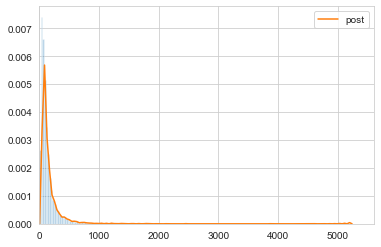

In [135]:
#!!! Améliorer le graphique pour la présentation
plt.hist(nbr_mots, alpha=0.3, range=(
    0, 5600),  bins=200, density=True)
sns.kdeplot(nbr_mots)

plt.xlim(0, 5600)
plt.rcParams['figure.figsize'] = (20, 20)

In [136]:
y_train_clean.head()

4183                     javascript exception
13188      database-design latitude-longitude
2147                android crash stack-trace
7588     c# .net exception exception-handling
12329                     javascript html rss
Name: tags, dtype: object

In [137]:
nbr_tags = y_train_clean.apply(lambda row : len(row.split()))

In [138]:
nbr_tags.describe()

count    9843.000000
mean        3.207152
std         1.185010
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: tags, dtype: float64

Le nombre de tags varie de 1 à 6 avec la valeurs médiane de 3 tags par post.

## Fréquences des expressions

### Bag of words

Nous allons afficher les fréquences de 50 features les plus utilisées :

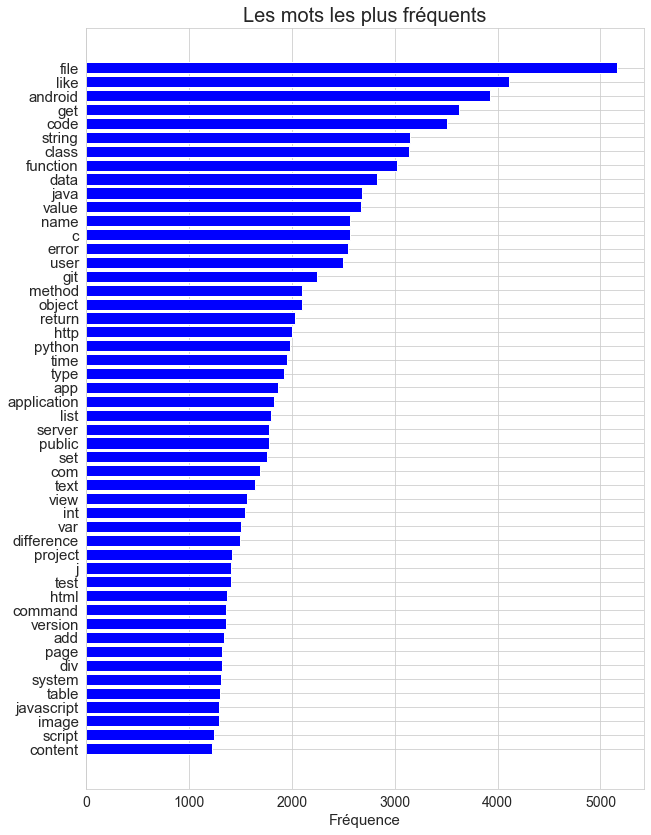

In [139]:
freq_features_50 = freq_features_bow[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

Faisons le même affichage pour les tags.

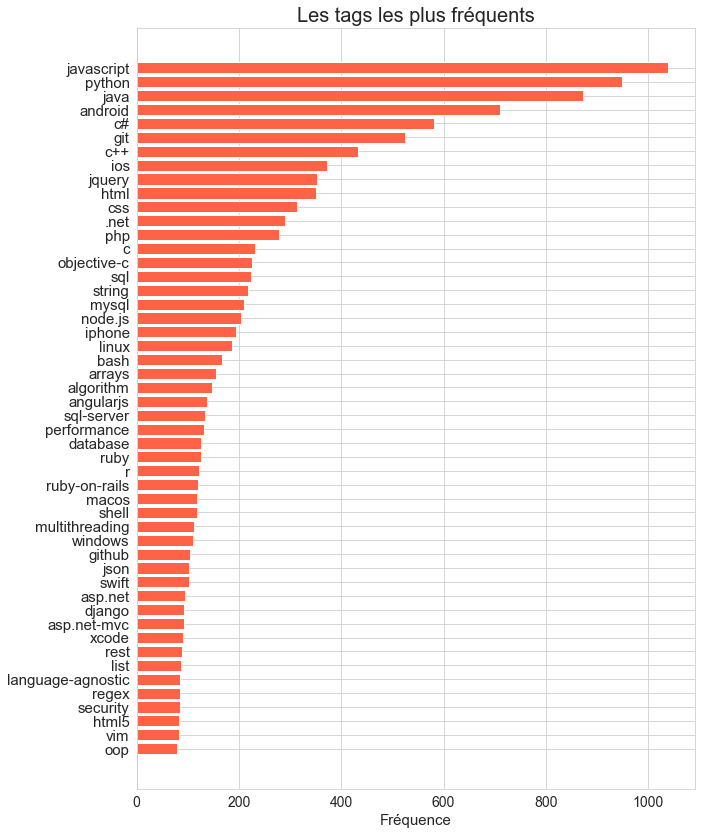

In [140]:
freq_target_50 = freq_target_bow[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='tomato', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

### TF-IDF

Pour pouvoir faire comparaison, nous allons aussi afficher les mot les plus fréquentes en se basant sur les fréquences relatives TF-IDF :

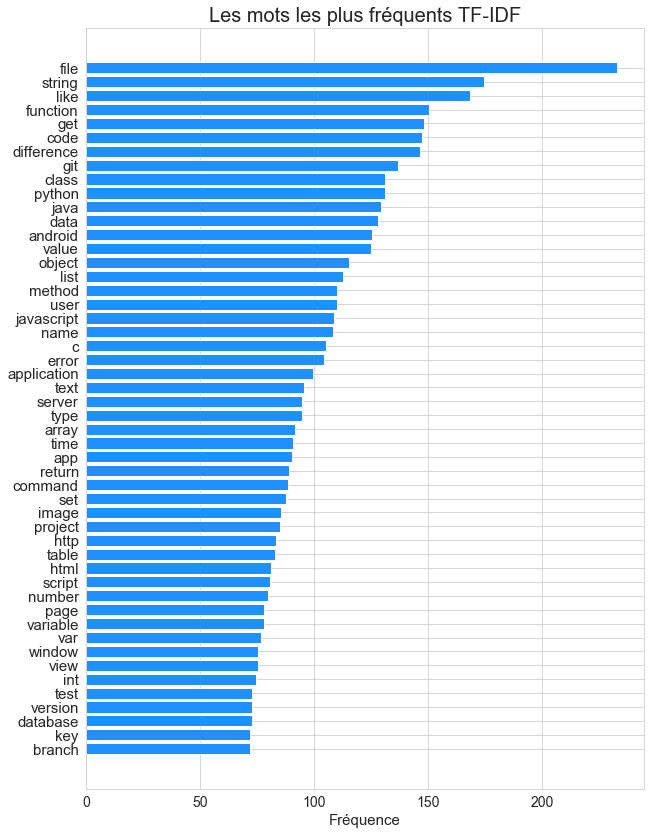

In [141]:
freq_features_50 = freq_features_tfidf[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='dodgerblue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

Affichons également un graphique de tags :

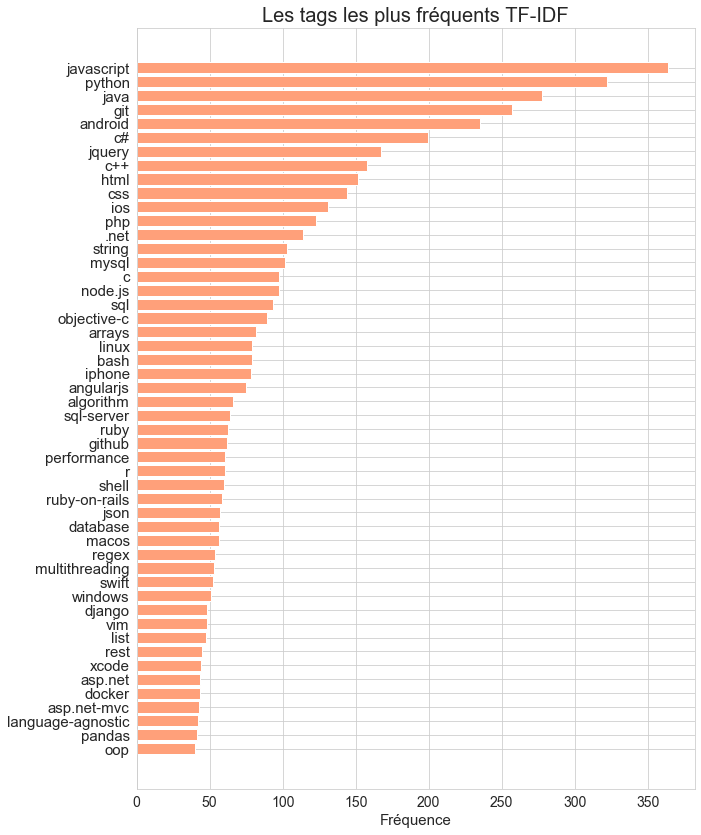

In [142]:
freq_target_50 = freq_target_tfidf[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='lightsalmon', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

Nous constatons seulement légères différences par rapport à la méthode bag of words.

## Réduction de dimension

### Analyse en composantes principales

Nous allons effectuer une analyse en composante principales afin de visualiser les données. L'ACP va être performée sur les données transformées par TF-IDF.

Nous avons 25000 posts, le calcul de ACP est donc assez exigeant sur une matrice 25 000 x 5 000.

Nous allons utiliser un échantillon de 500 premiers posts qui représentent 2% de données. 

#### Création d'échantillon

In [143]:
X_train_tfidf_sample = X_train_tfidf[:500]

Afin de pouvoir afficher des tags qui nous intéressent, nous allons aussi échantilloner les tags cleanés correspondants.

In [144]:
y_train_clean_sample = y_train_clean[:500].reset_index(drop=True)

#### Créer le modèle

In [145]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_tfidf_sample)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])

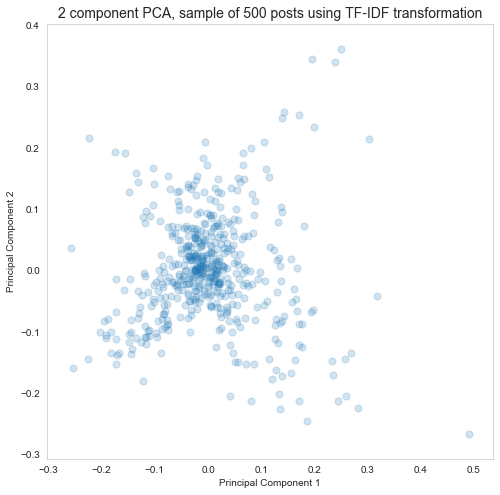

In [146]:
# Scatterplot of all sample posts
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component PCA, sample of 500 posts using TF-IDF transformation', fontsize=14)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

####  Affichage de groupes de tags

Nous allons choisir 12 tags à afficher - essayeons de prendre 4 groupes de 3 tags avec des sujets qui sont similaire dans chaque groupe. Afin de trouver la position des tags, nous allons construire une fonction qui renvoi un échantillon de n indexes des expressions qui contient un mot donné. 

In [147]:
def choose_expression(ser, word, n=3):

    """Function which returns a list of n random index positions of an expression containing indicated string

    Inputs:

    - ser : a serie of expressions
    - word : a string to search for
    - n : number of returned positions (n=3 by default)

    Output:

    - a list of n positions
    """

    index_list = []

    for i in range(len(ser)):
        if word in ser[i]:
            index = i
            index_list.append(index)
        else:
            pass
    
    index_list = random.sample(index_list, n)
    
    return index_list

In [148]:
# Create the first list of positions containing the word "javascript"
liste_javascript = choose_expression(y_train_clean_sample, 'javascript')
liste_javascript

[431, 127, 0]

In [149]:
# Check
print(y_train_clean_sample[liste_javascript[0]])
print(y_train_clean_sample[liste_javascript[1]])
print(y_train_clean_sample[liste_javascript[2]])

javascript onclick addeventlistener
javascript flash download
javascript exception


In [150]:
# Create other lists containing "python", "git" and "android"
liste_python = choose_expression(y_train_clean_sample, 'python')
liste_git = choose_expression(y_train_clean_sample, 'git')
liste_android = choose_expression(y_train_clean_sample, 'android')

In [151]:
# Create an overall list
chosen_tags_index = liste_javascript + liste_python + liste_git + liste_android

In [152]:
chosen_tags_index

[431, 127, 0, 113, 83, 382, 236, 387, 428, 304, 281, 350]

In [153]:
# View the chosen tags
chosen_tags = y_train_clean_sample[chosen_tags_index] 
chosen_tags

431                javascript onclick addeventlistener
127                          javascript flash download
0                                 javascript exception
113                             python django django-q
83               python numpy tensorflow deep-learning
382                                   python emacs ssh
236                             git git-merge-conflict
387                                                git
428                                     git git-branch
304            android android-intent contact whatsapp
281    android layout android-widget lifecycle measure
350                                    android install
Name: tags, dtype: object

In [154]:
chosen_principalDf = principalDf.iloc[chosen_tags_index]
chosen_principalDf

,principal component 1,principal component 2
431,-0.054311,-0.009281
127,-0.195446,-0.082982
0,-0.021045,0.018683
113,0.015120,0.002014
83,-0.020945,0.068218
382,0.024816,-0.075193
236,-0.192544,-0.110847
387,-0.183244,-0.134601
428,-0.144828,-0.100063
304,-0.058221,0.127904


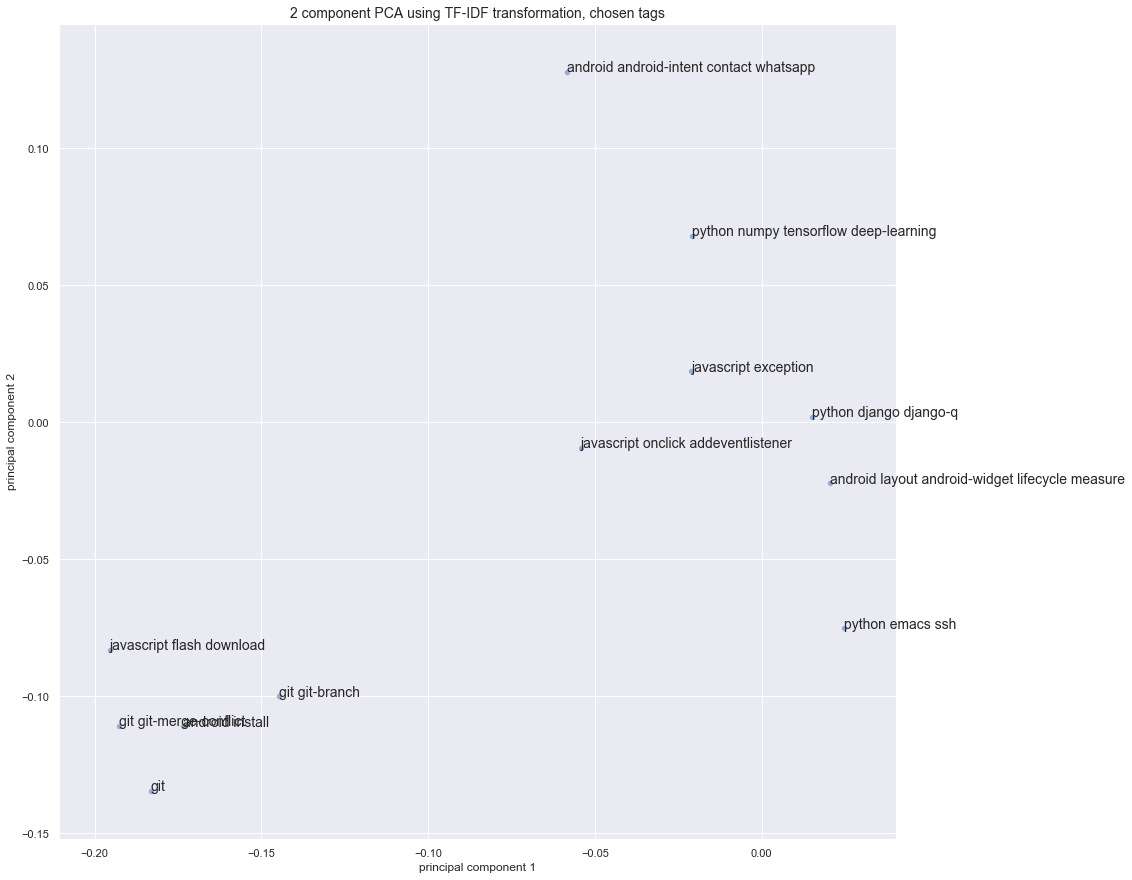

In [155]:
# Scatterplot of chosen tags
# !!! Comment faire pour éviter le texte qui se chévauche ?

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (15, 15))

ax.set_title('2 component PCA using TF-IDF transformation, chosen tags', fontsize=14)

sns.scatterplot(chosen_principalDf['principal component 1'],
           chosen_principalDf['principal component 2'], alpha = 0.5)
 
for i in chosen_tags.index:    
    
    plt.text(chosen_principalDf['principal component 1'][i], chosen_principalDf['principal component 2'][i], 
             chosen_tags[i],fontsize = 14)

plt.show()

Nous pouvons voir que les point représentants des posts sont proches selon le groupe - les tags contenant "python" sont en haut à gauche, "git"s sont en haut à droite, "javascript" se mélange un peu avec "android", mais les groupes sont quand même séparables. 

### t-SNE 

#### Créer le modèle

In [156]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

In [157]:
tsne_df = tsne.fit_transform(X_train_tfidf_sample)

In [158]:
principalDf = pd.DataFrame(data=tsne_df, columns=[
                           'principal component 1', 'principal component 2'])

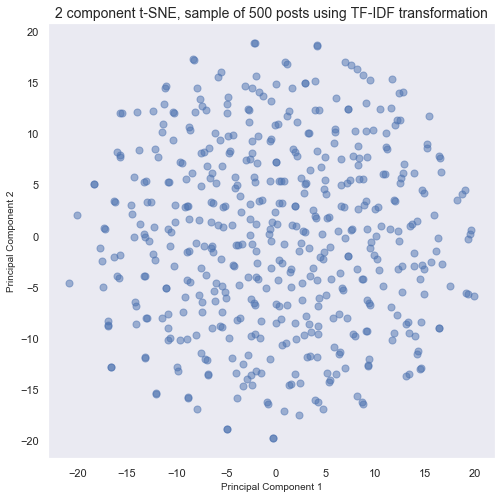

In [159]:
# Scatterplot of all sample posts
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component t-SNE, sample of 500 posts using TF-IDF transformation', fontsize=14)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.5)
ax.grid()

Le nuage de points créé à l'aide de t-SNE semble former un rond.

#### Affichage de groupes de tags

In [160]:
chosen_principalDf = principalDf.iloc[chosen_tags_index]

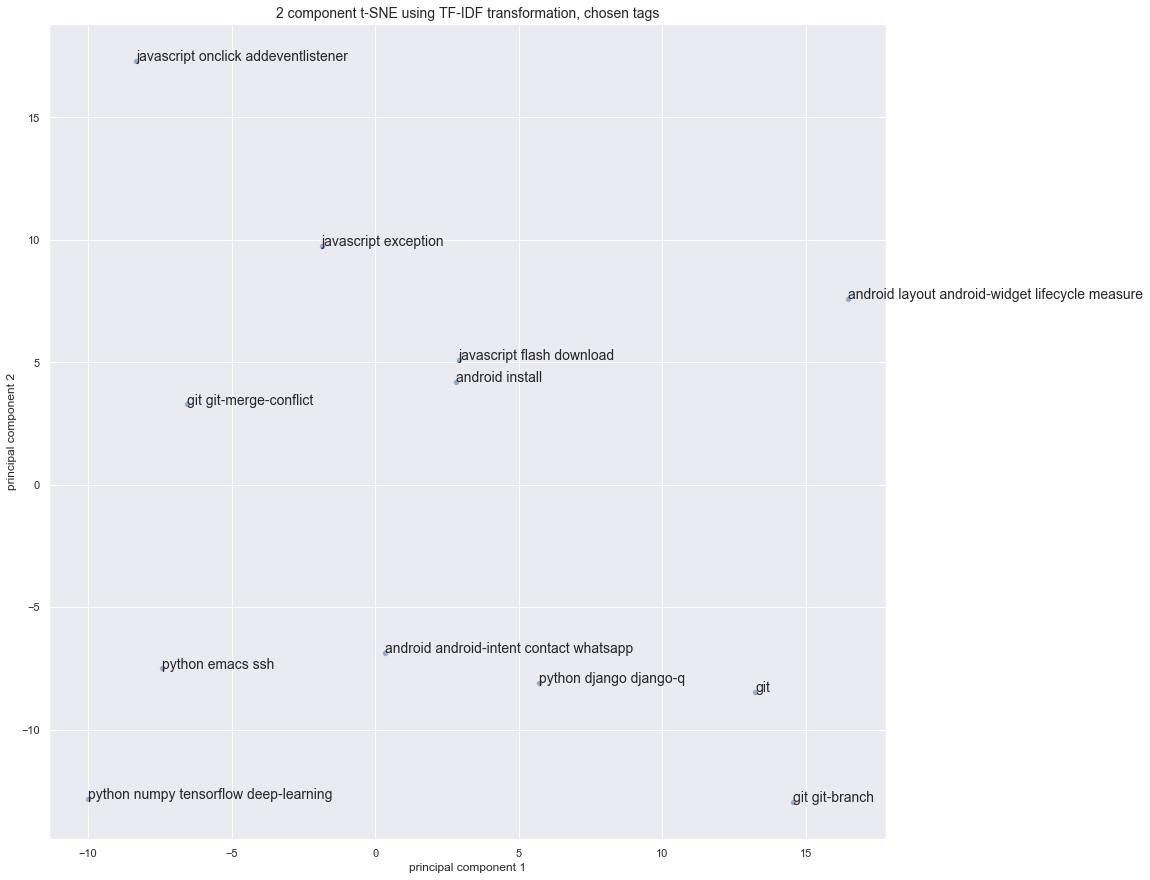

In [161]:
# Scatterplot of chosen tags

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (15, 15))

ax.set_title('2 component t-SNE using TF-IDF transformation, chosen tags', fontsize=14)

sns.scatterplot(chosen_principalDf['principal component 1'],
           chosen_principalDf['principal component 2'], alpha = 0.5)
 
for i in chosen_tags.index:    
    
    plt.text(chosen_principalDf['principal component 1'][i], chosen_principalDf['principal component 2'][i], 
             chosen_tags[i],fontsize = 14)

plt.show()

Nous pouvons trouver certains tags avec la même thématique proche les uns des autres (git, python), mais la séparation n'est pas très prononcée.